Data: https://www.kaggle.com/datasets/ahmedadam415/digital-currency-time-series 

### Primary Goals:

- Predict daily bitcoin stock
### Assignment Specs:

- You need to explore multiple recurrent neural network models to solve this problem. 
- The dataset includes multiple time series. You may choose which one you want to model.
- Your submission should be built and written with non-experts as the target audience. All of your code should still be included, but do your best to narrate your work in accessible ways.

### Import Data

In [2]:
import pandas as pd
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahmedadam415/digital-currency-time-series")

# Full file path
file_path = os.path.join(path, "dc.csv")

# Load into DataFrame
df = pd.read_csv(file_path)

# make sure in datetime type 
df['date'] = pd.to_datetime(df['Unnamed: 0'])

# drop any NaNs
df = df.dropna()

# Sort chronologically
df = df.sort_values('date') 

bitcoin_close = df[["date", "close_USD"]]

bitcoin_close.head()

,date,close_USD
999,2018-05-07,9365.00
998,2018-05-08,9187.56
997,2018-05-09,9310.00
996,2018-05-10,9002.20
995,2018-05-11,8400.00


### Core Features of Function Below:
1. Model Selection
- Accepts model_type='RNN', 'LSTM', or 'GRU' to dynamically switch between these architectures.
2. Flexible History Window Testing
- Loops through multiple history_steps_list values (e.g., 1, 3, 5) to test how much past data should be used to predict the future.
3. Train-Test Ratio Evaluation
- Loops through different train_ratios (e.g., 0.7, 0.8, 0.9) to find the optimal training split.
4. Sequence Creation
- Converts raw price data into sequences (X) and targets (y) for time series prediction using sliding windows.
5. Data Normalization
- Scales the input data to the [0, 1] range using MinMaxScaler to improve neural network performance.
6. Dynamic Model Building
- Builds a Keras Sequential model using the selected layer (SimpleRNN, LSTM, or GRU) with a Dense output layer.
7. Training with Early Stopping
- Uses EarlyStopping callback to prevent overfitting by stopping training when validation loss stops improving.
8. Performance Evaluation Metrics
- Computes:
    - MAE (Mean Absolute Error)
    - RMSE (Root Mean Squared Error)
    - MAPE (Mean Absolute Percentage Error)
    - R² Score (explained variance)
9. Best Model Selection
- Picks the model with the lowest MAE from all combinations tested.
10. Prediction Visualization
- Plots the actual vs predicted prices over time for the best model using proper date alignment.

In [3]:
def find_best_model(df, model_type='RNN', price_col='Close', date_col='Date',
                    history_steps_list=[1, 3, 5], train_ratios=[0.7, 0.8, 0.9]):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Dense
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd


    dates = df[date_col].values
    data_series = df[price_col]

    # Normalize
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_series.values.reshape(-1, 1))

    def create_sequences(data, history=3):
        X, y = [], []
        for i in range(len(data) - history):
            X.append(data[i:i+history])
            y.append(data[i+history])
        return np.array(X), np.array(y)

    results = []

    for history in history_steps_list:
        X, y = create_sequences(scaled_data, history)
        X = X.reshape((X.shape[0], X.shape[1], 1))
        dates_seq = dates[history:]  # align with y

        for train_ratio in train_ratios:
            split = int(len(X) * train_ratio)
            X_train, X_test = X[:split], X[split:]
            y_train, y_test = y[:split], y[split:]
            test_dates = dates_seq[split:]

            model = Sequential()
            model.add(Input(shape=(history, 1)))

            if model_type == 'RNN':
                model.add(SimpleRNN(32, activation='relu'))
            elif model_type == 'LSTM':
                model.add(LSTM(32))
            elif model_type == 'GRU':
                model.add(GRU(32))
            else:
                raise ValueError("model_type must be 'RNN', 'LSTM', or 'GRU'")

            model.add(Dense(1))
            model.compile(optimizer='adam', loss='mse')
            es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

            preds = model.predict(X_test)
            preds_inv = scaler.inverse_transform(preds)
            y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

            mae = mean_absolute_error(y_test_inv, preds_inv)
            rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
            mape = mean_absolute_percentage_error(y_test_inv, preds_inv)
            r2 = r2_score(y_test_inv, preds_inv)

            results.append({
                'history': history,
                'train_ratio': train_ratio,
                'mae': mae,
                'rmse': rmse,
                'mape': mape,
                'r2': r2,
                'preds_inv': preds_inv,
                'y_test_inv': y_test_inv,
                'dates': test_dates
            })

    # Best by MAE
    best = min(results, key=lambda x: x['mae'])

    print(f"\nBest {model_type} Model:")
    print(f"  History: {best['history']} • Train: {int(best['train_ratio']*100)}%")
    print(f"  MAE:  {best['mae']:.2f}")
    print(f"  RMSE: {best['rmse']:.2f}")
    print(f"  MAPE: {best['mape']*100:.2f}%")
    print(f"  R²:   {best['r2']:.4f}")

    # Plot
    n = min(300, len(best['y_test_inv']))
    plt.figure(figsize=(12, 5))
    plt.plot(best['dates'][-n:], best['y_test_inv'][-n:], label='Actual', color='red')
    plt.plot(best['dates'][-n:], best['preds_inv'][-n:], label='Predicted', color='blue')
    plt.title(f"{model_type} • History={best['history']} • Train={int(best['train_ratio']*100)}%")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return

### Simple RNN

2025-05-16 11:33:28.771093: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step

Best RNN Model:
  History: 5 • Train: 70%
  MAE:  506.33
  RMSE: 857.82
  MAPE: 3.20%
  R²:   0.9887


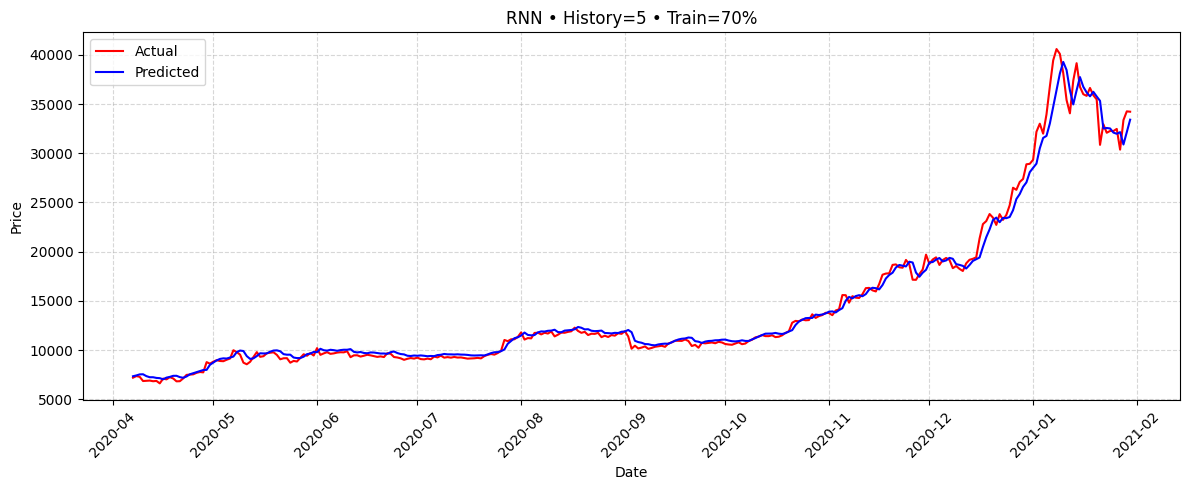

In [4]:
find_best_model(bitcoin_close, model_type='RNN', price_col='close_USD', date_col='date')

### LSTM

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

Best LSTM Model:
  History: 1 • Train: 70%
  MAE:  519.53
  RMSE: 846.19
  MAPE: 3.26%
  R²:   0.9890


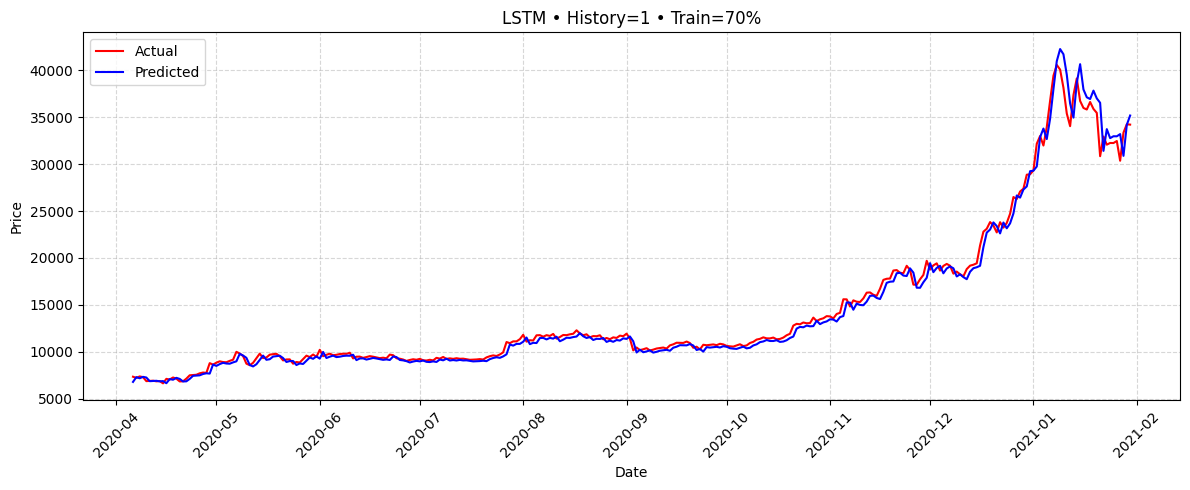

In [5]:
find_best_model(bitcoin_close, model_type='LSTM', price_col='close_USD', date_col='date')

### GRU

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

Best GRU Model:
  History: 1 • Train: 70%
  MAE:  425.28
  RMSE: 748.52
  MAPE: 2.56%
  R²:   0.9914


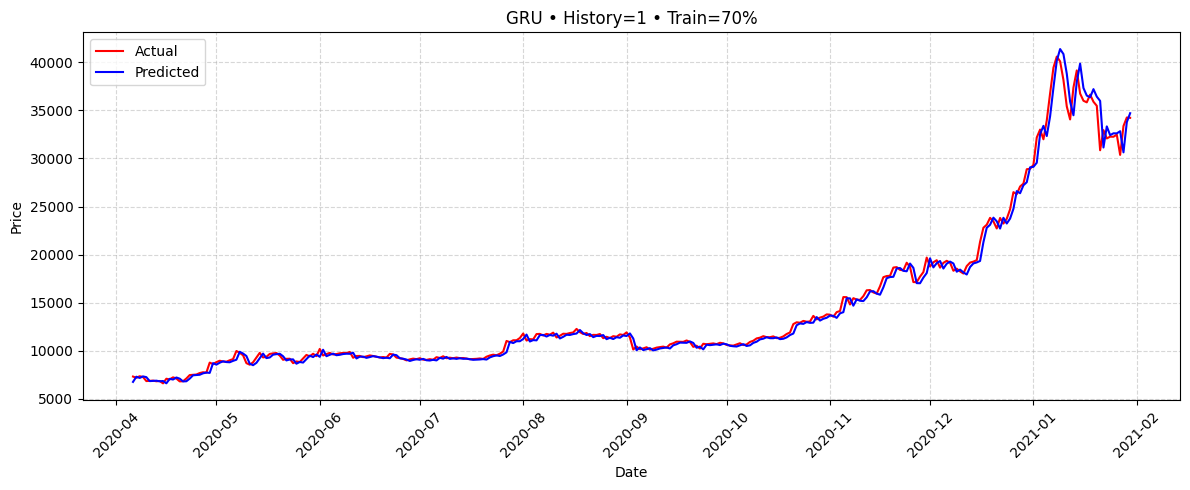

In [6]:
find_best_model(bitcoin_close, model_type='GRU', price_col='close_USD', date_col='date')

The best-performing model identified was a GRU (Gated Recurrent Unit) network trained on 70% of the data using a history window of 1 time step. This configuration achieved strong predictive accuracy, with a Mean Absolute Error (MAE) of 425.28 and a Root Mean Squared Error (RMSE) of 748.52, indicating that on average, its predictions were within a few hundred dollars of actual Bitcoin prices. The Mean Absolute Percentage Error (MAPE) was just 2.56%, suggesting high reliability even relative to price scale. Additionally, the model achieved an R² score of 0.9914, meaning it was able to explain over 99% of the variance in the data — a clear indication of excellent fit and forecasting performance.